In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Cargar la base consolidada (debe estar en la misma carpeta)
file_path = 'Base_Datos_Consolidada_Final.xlsx'
df = pd.read_excel(file_path)
df.head()


,Año,Municipio,Area Sembrada,Area Cosechada,Produccion (ton),Rendimiento (ha/ton),Cultivo,Temperatura,Temperatura_MIN,Temperatura_MAX,precipitation (mm),relative_humidity_2m (%),direct_radiation (W/m²),pH,Densidad g/cm3,NDVI,NDMI
0,2020,DUITAMA,4.00,1.50,3.0,2.00,Arandano,14.4525,6.8975,21.6525,43.12,83.286667,4199.922449,5.727318,1.145887,0.485113,0.106287
1,2020,DUITAMA,1.16,0.00,0.0,0.00,Fresa,14.4525,6.8975,21.6525,43.12,83.286667,4199.922449,5.727318,1.145887,0.485113,0.106287
2,2020,DUITAMA,32.00,30.04,1364.8,45.43,Lechuga,14.4525,6.8975,21.6525,43.12,83.286667,4199.922449,5.727318,1.145887,0.485113,0.106287
3,2020,DUITAMA,80.00,78.80,1940.0,24.62,Cebolla de bulbo,14.4525,6.8975,21.6525,43.12,83.286667,4199.922449,5.727318,1.145887,0.485113,0.106287
4,2020,DUITAMA,20.00,19.20,350.0,18.23,Espinaca,14.4525,6.8975,21.6525,43.12,83.286667,4199.922449,5.727318,1.145887,0.485113,0.106287


In [3]:
# Entrenar y evaluar modelos
resultados = []

for cultivo in df['Cultivo'].unique():
    df_cultivo = df[df['Cultivo'] == cultivo]
    if len(df_cultivo) >= 4:
        X = df_cultivo[['Temperatura', 'Temperatura_MIN', 'Temperatura_MAX',
                        'precipitation (mm)', 'relative_humidity_2m (%)',
                        'direct_radiation (W/m²)', 'pH', 'Densidad g/cm3',
                        'NDVI', 'NDMI']]
        y = df_cultivo['Rendimiento (ha/ton)']

        modelo = RandomForestRegressor(n_estimators=100, random_state=42)
        modelo.fit(X, y)
        y_pred = modelo.predict(X)

        resultados.append({
            'Cultivo': cultivo,
            'MAE': mean_absolute_error(y, y_pred),
            'RMSE': mean_squared_error(y, y_pred, squared=False),
            'R2': r2_score(y, y_pred)
        })

df_resultados = pd.DataFrame(resultados)
df_resultados


,Cultivo,MAE,RMSE,R2
0,Arandano,0.305750,0.318931,0.842300
1,Fresa,3.604275,4.704241,0.858373
2,Lechuga,3.095950,3.519761,0.831262
3,Cebolla de bulbo,0.386625,0.448607,0.787122
4,Espinaca,0.288225,0.295446,0.877494


In [4]:
# Promedios históricos 2020–2023
promedios = df[df['Año'] <= 2023].groupby('Cultivo').agg({
    'Temperatura': 'mean',
    'Temperatura_MIN': 'mean',
    'Temperatura_MAX': 'mean',
    'precipitation (mm)': 'mean',
    'relative_humidity_2m (%)': 'mean',
    'direct_radiation (W/m²)': 'mean',
    'pH': 'mean',
    'Densidad g/cm3': 'mean',
    'NDVI': 'mean',
    'NDMI': 'mean'
}).reset_index()

# Predicción con modelo entrenado
predicciones = []
for i, row in promedios.iterrows():
    cultivo = row['Cultivo']
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    
    df_cultivo = df[df['Cultivo'] == cultivo]
    X = df_cultivo[['Temperatura', 'Temperatura_MIN', 'Temperatura_MAX',
                    'precipitation (mm)', 'relative_humidity_2m (%)',
                    'direct_radiation (W/m²)', 'pH', 'Densidad g/cm3',
                    'NDVI', 'NDMI']]
    y = df_cultivo['Rendimiento (ha/ton)']
    modelo.fit(X, y)

    X_pred = row.drop('Cultivo').values.reshape(1, -1)
    pred = modelo.predict(X_pred)[0]

    predicciones.append({'Cultivo': cultivo, 'Predicción 2024 (ton/ha)': round(pred, 2)})

df_pred = pd.DataFrame(predicciones)
df_pred


C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,Cultivo,Predicción 2024 (ton/ha)
0,Arandano,1.30
1,Cebolla de bulbo,24.42
2,Espinaca,17.46
3,Fresa,15.03
4,Lechuga,30.00


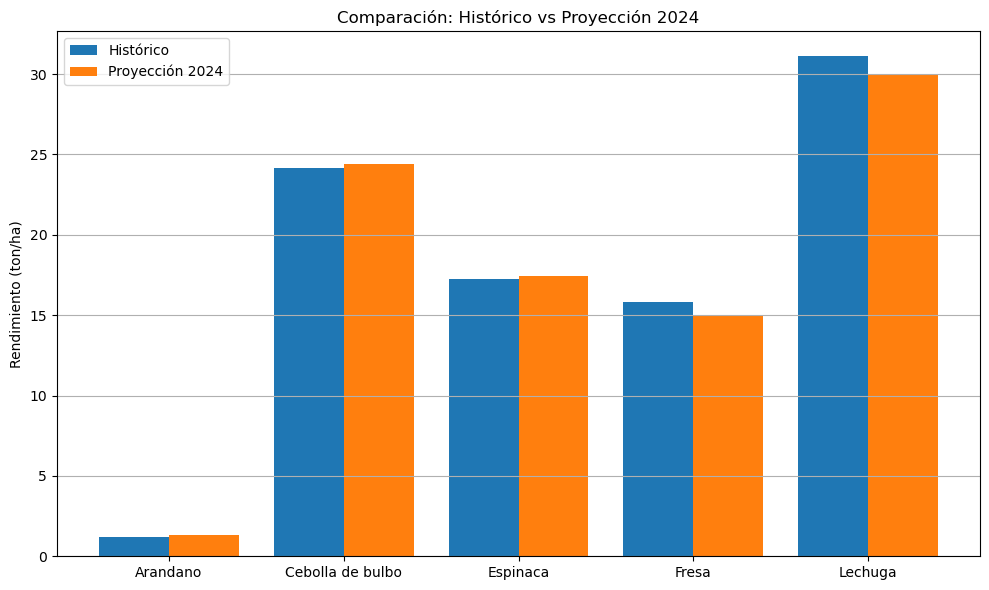

In [5]:
# Promedio histórico
historico = df[df['Año'] <= 2023].groupby('Cultivo')['Rendimiento (ha/ton)'].mean().reset_index()
historico.rename(columns={'Rendimiento (ha/ton)': 'Histórico (2020–2023)'}, inplace=True)

# Unir con predicciones
historico['Proyección 2024'] = df_pred['Predicción 2024 (ton/ha)']

# Graficar
plt.figure(figsize=(10,6))
x = range(len(historico))
bar_width = 0.4

plt.bar([i - bar_width/2 for i in x], historico['Histórico (2020–2023)'], width=bar_width, label='Histórico')
plt.bar([i + bar_width/2 for i in x], historico['Proyección 2024'], width=bar_width, label='Proyección 2024')

plt.xticks(ticks=x, labels=historico['Cultivo'])
plt.ylabel("Rendimiento (ton/ha)")
plt.title("Comparación: Histórico vs Proyección 2024")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


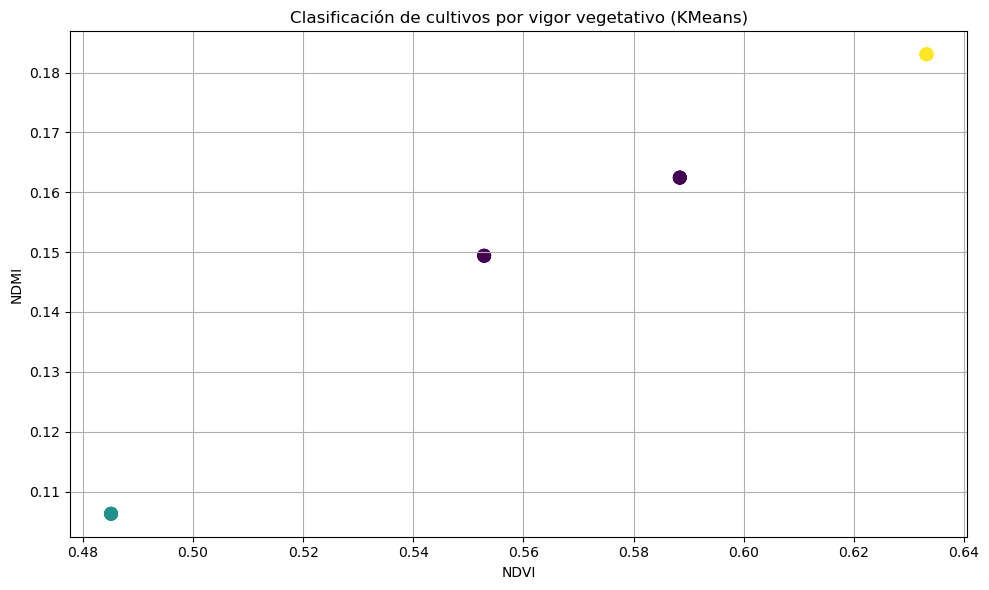

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables NDVI y NDMI
X_cluster = df[['NDVI', 'NDMI']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Grupo Vegetativo'] = kmeans.fit_predict(X_scaled)

# Visualizar
plt.figure(figsize=(10,6))
plt.scatter(df['NDVI'], df['NDMI'], c=df['Grupo Vegetativo'], cmap='viridis', s=80)
plt.xlabel('NDVI')
plt.ylabel('NDMI')
plt.title('Clasificación de cultivos por vigor vegetativo (KMeans)')
plt.grid(True)
plt.tight_layout()
plt.show()
